In [24]:
from typing import *
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
from NBTfidf import NBTfidfVectorizer
import csv
from math import sqrt
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch
from dataset import HANData
from torch.utils.data import DataLoader

model = None
data = pd.read_csv('svm_han_corpus.csv')

In [25]:

HAN = 'out/whole_model_han.pt'
han = torch.load(HAN)
VOCAB_PATH = 'vocab.pkl'

In [26]:
data.rename(columns={
    'Tweet_text':'tweets'
}, inplace=True)
data = data.drop(columns=['Unnamed: 0'])

In [27]:
test_params = {"batch_size": 64,
                   "shuffle": False,
                   "drop_last": False}
my_set = HANData(
    df=data,
    dict_path=VOCAB_PATH,
    task='PerformHAN'
)

my_generator = DataLoader(my_set, **test_params)


In [32]:
# data.drop(columns=['Unnamed: 0'], inplace=True)
te_label_ls = []
te_pred_ls = []
for te_feature, te_label in my_generator:
    num_sample = len(te_label)
    with torch.no_grad():
        han._init_hidden_state(num_sample)
        te_predictions = han(te_feature)

    te_label_ls.extend(te_label.clone().cpu())
    te_pred_ls.append(te_predictions.clone().cpu())

In [50]:
te_pred = torch.cat(te_pred_ls, 0)
preds = np.argmax(te_pred.numpy(), -1)

In [52]:
data['HAN_out'] = preds

In [81]:
def convert_long_short(txt):
    if txt.lower() == 'long':
        return 1
    else:
        return 0

In [83]:
data['long_or_short_tweet'] = data['long_or_short_tweet'].apply(lambda elem: convert_long_short(elem))

In [84]:
data.to_csv('svm_data_with_HAN.csv')

In [85]:
training_feats = list(data.columns)
training_feats.remove('judgements')
training_feats.remove('tweets')


In [100]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True)
metrics_ls = []
i = 0
X = data[training_feats]
y = data['judgements']
# print(kfold.split(X,y))
for train, test in kfold.split(X,y):
    print('TRAIN : {0}, TEST: {1}'.format(train.shape,test.shape))
    # continue
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    clf = SVC()
    clf.fit(X_train, y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    report = sklearn.metrics.classification_report(y_true, y_pred,output_dict=True)
    weighted_f1 = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    macro_f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    micro_f1 = sklearn.metrics.f1_score(y_true, y_pred, average='micro')
    rsme = sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    metrics = {
        'accuracy':report['accuracy'],
        'macro_avg_precision':report['macro avg']['precision'],
        'macro_avg_recall':report['macro avg']['recall'],
        'macro_avg_f1':report['macro avg']['f1-score'],
        'weighted_avg_precision':report['weighted avg']['precision'],
        'weighted_avg_recall':report['weighted avg']['recall'],
        'weighted_avg_f1':report['weighted avg']['f1-score'],
        'weighted_f1':weighted_f1 ,
        'macro_f1':macro_f1,
        'micro_f1':micro_f1,
        'rsme':rsme
    }
    metrics_ls.append(metrics)


TRAIN : (11724,), TEST: (2935,)
TRAIN : (11726,), TEST: (2933,)
TRAIN : (11726,), TEST: (2933,)
TRAIN : (11730,), TEST: (2929,)
TRAIN : (11730,), TEST: (2929,)


In [101]:
svm_metrics = pd.DataFrame(metrics_ls)

In [126]:
len(svm_metrics.columns)

11

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

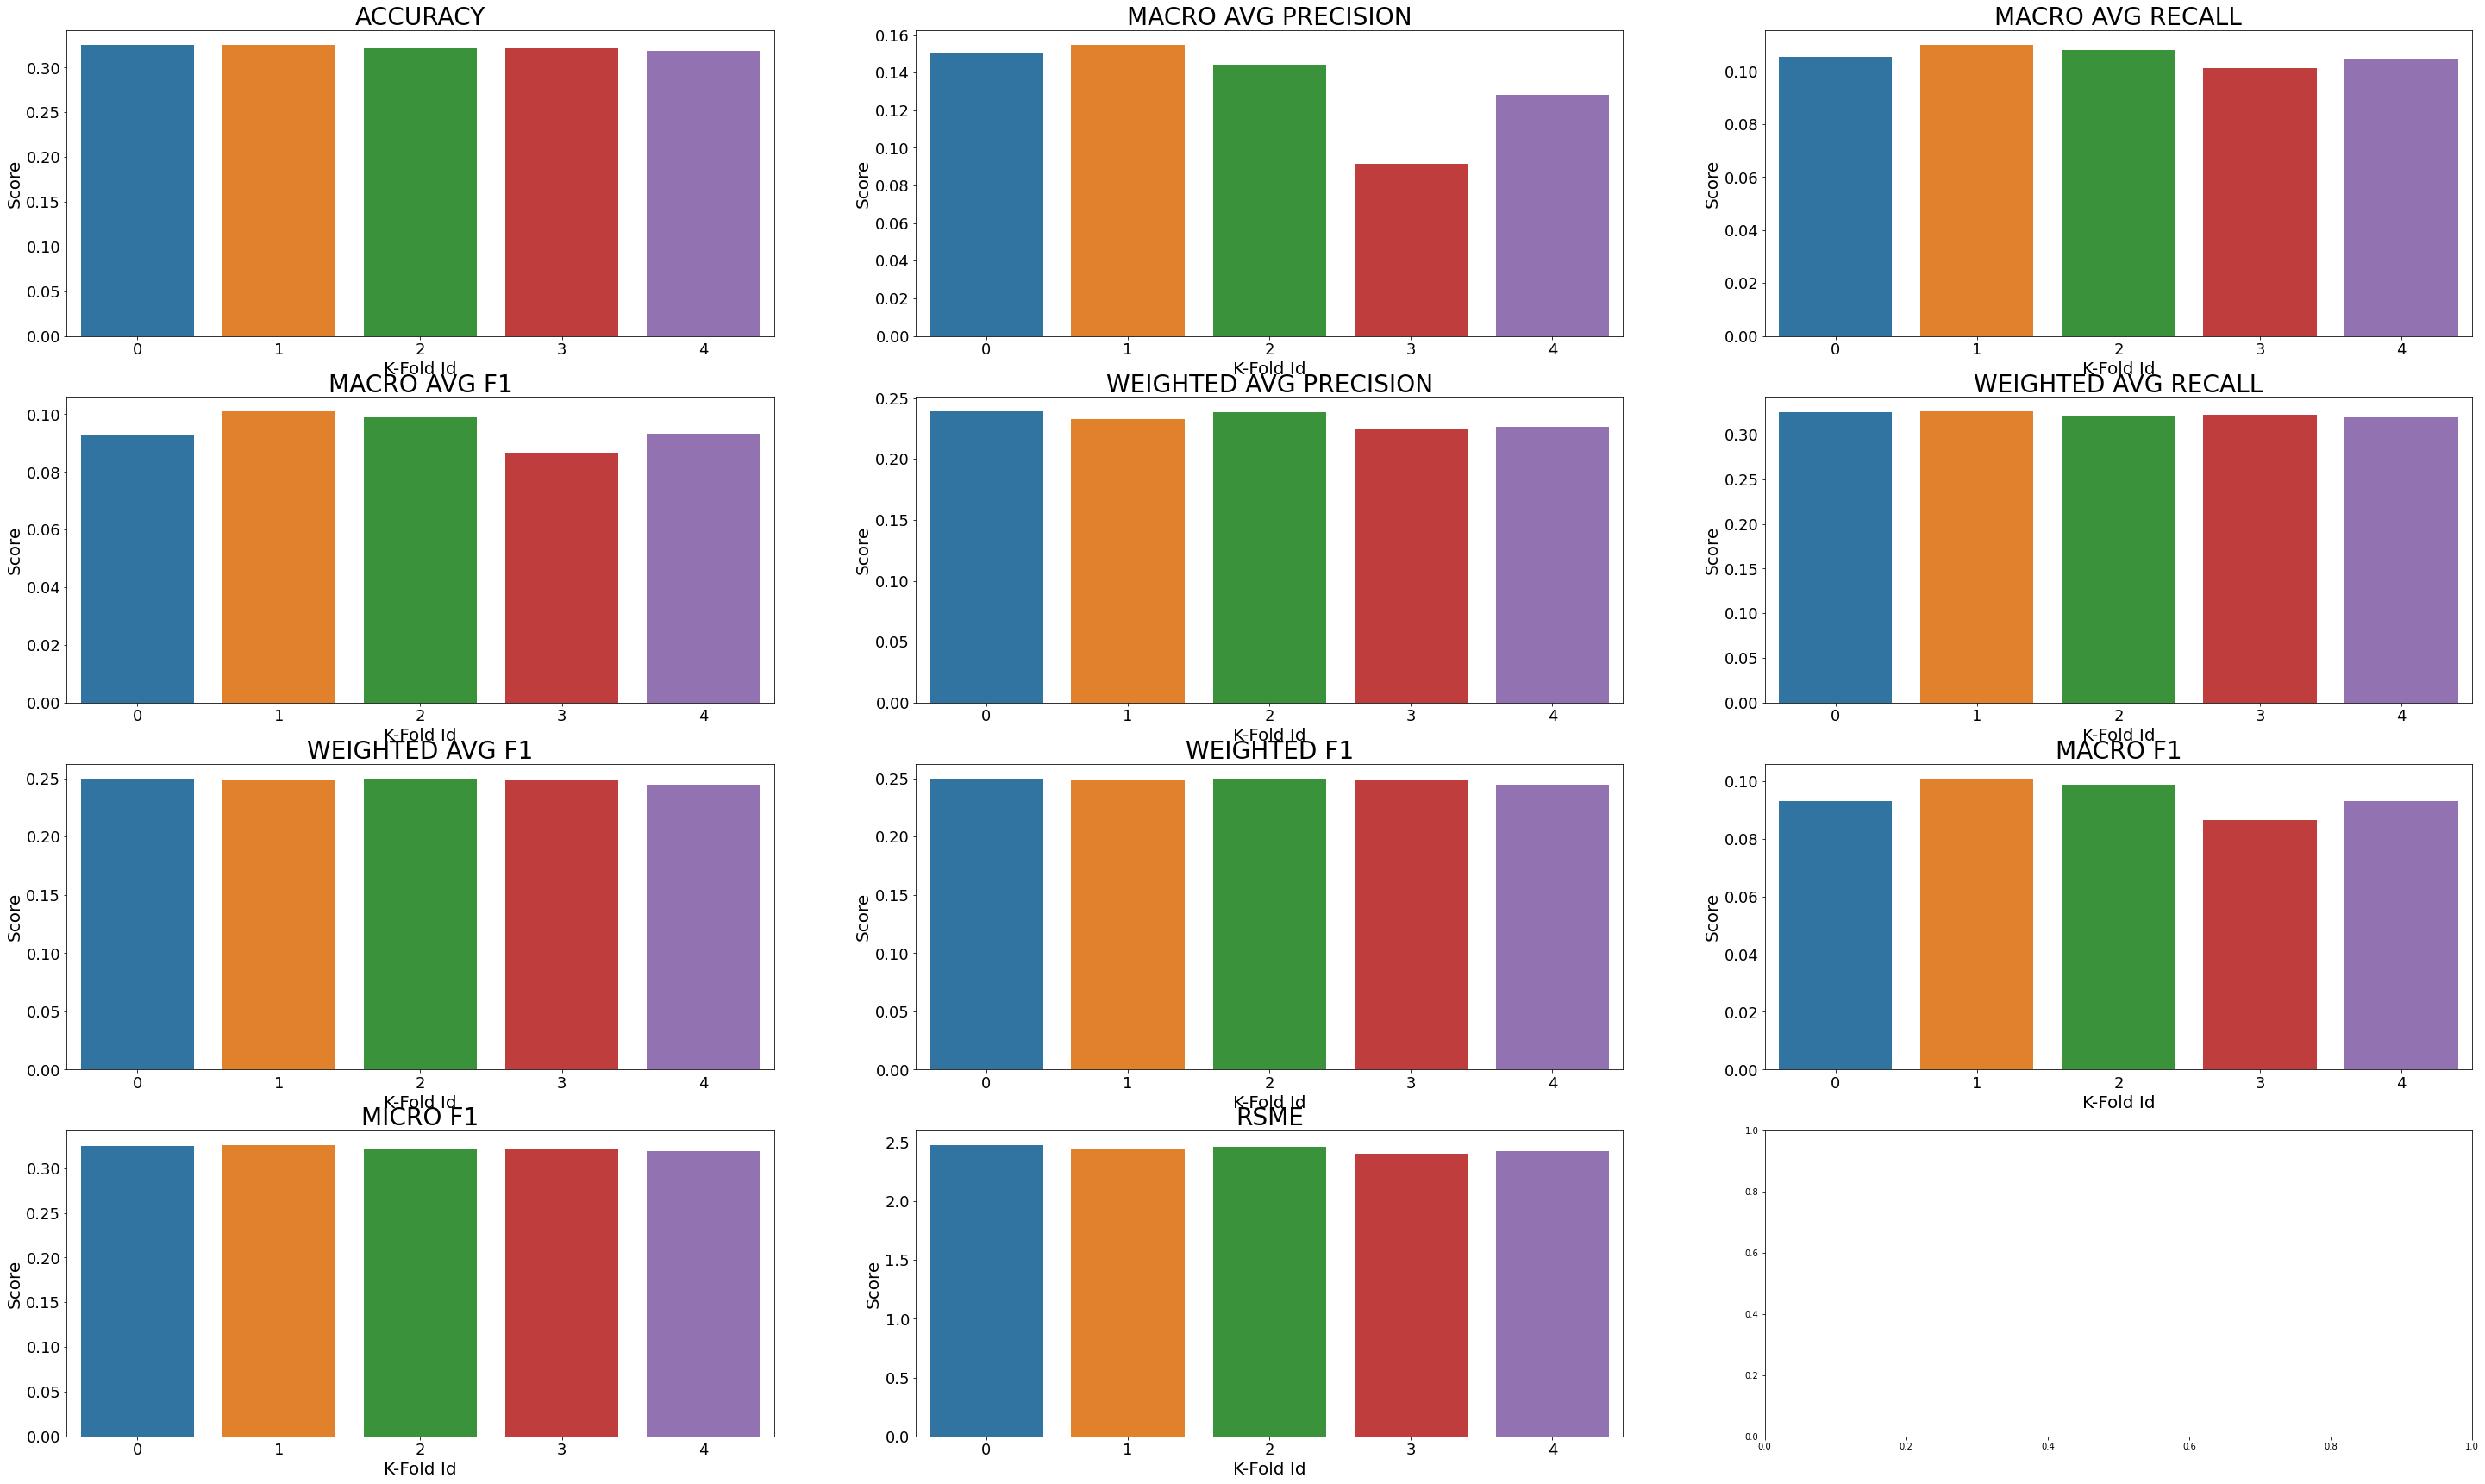

In [148]:
fig, ax = plt.subplots(4,3,figsize=(50,30))

for id,col in enumerate(svm_metrics.columns):
    x = int((id-id%3)/3)
    y = id%3
    sns.barplot(ax=ax[x,y], x=svm_metrics.index, y=svm_metrics[col])
    ax[x,y].set_title(col.replace('_',' ').upper(), size=28)
    ax[x,y].set_xlabel('K-Fold Id', size=20)
    ax[x,y].set_ylabel('Score', size=20)
    ax[x,y].tick_params(axis='both', which='major', labelsize=18)


In [146]:
fig.savefig('SVM_result.jpg')